# Predict Customer Churn

## Import Libraries

In [108]:
from datetime import datetime
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, classification_report, precision_score, \
                            recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
import warnings

In [109]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [110]:
# config data
logging_path = 'logs/results.log'
path = "data/bank_data.csv"
coef_list_path = 'artifacts/coef_list.txt'

In [111]:
# Instantiate logging
logging.basicConfig(
    filename=logging_path,
    level=logging.INFO,
    filemode='w',
    format='%(name)s - %(levelname)s - %(message)s')

## Import Data

In [112]:
def import_data(path):
    
    try:
        df = pd.read_csv(path, index_col = 0)
    except Exception as e:
        logging.error(f"ERROR: Unable to load file {path} {str(e)}")
        
    return df

## Perform EDA

In [113]:
def perform_eda(df):
    
    # Check the size
    if df.shape[0] > 1000 and df.shape[1] > 20:
        pass
    else:
        logging.error(f"ERROR:File is not of expected shape. The models will not work.")
    
    # Check for nulls
    if df.isnull().sum().sum() == 0:
        pass
    else:
        logging.error(f"ERROR:There are nulls. Logistic Regression will fail.")
    
    # For console output
    display(df.describe())
    
    # Check for duplicates
    dups = df[df.duplicated()]
    if dups.shape[0] == 0:
        pass
    else:
        logging.error(f"ERROR:There are duplicates. Duplicate cleaning code does not exist in this program.")
    
    # Create a churn column to enable further analysis and then drop that column
    df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)
    df.drop(columns=["Attrition_Flag"], inplace=True)

    return df


In [114]:
def eda_plots(df, coef_list_path):
    
    # Produce plots and save as artifacts
    
    plt.figure(figsize=(20,10)) 
    df['Churn'].hist();
    plt.savefig('images/eda/Churn_hist.png')
    
    plt.figure(figsize=(20,10)) 
    df['Customer_Age'].hist()
    plt.savefig('images/eda/Customer_Age_hist.png')
    
    plt.figure(figsize=(20,10)) 
    df.Marital_Status.value_counts('normalize').plot(kind='bar')
    plt.savefig('images/eda/Marital_Status_bar.png')
    
    plt.figure(figsize=(20,10)) 
    sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True)
    plt.savefig('images/eda/Total_Trans_Ct_hist.png')
    
    # Run some correlations
    # Get the numeric columns
    numeric_df = df.select_dtypes(include=np.number)
    
    plt.figure(figsize=(20,10)) 
    sns.heatmap(numeric_df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
    plt.savefig('images/eda/Correlation_Heat_Map.png')
    
    # We are predicting Churn. Lets look at that in particular
    coef_list = [(df['Churn'].corr(numeric_df[col]), col) for col in numeric_df]
    coef_list.sort(reverse = True)
    
    # Specify the file path where you want to save the text file
    coef_list_path = 'artifacts/coef_list.txt'

    # Write the coefficients to the text file
    with open(coef_list_path, 'w') as file:
        for coef in coef_list:
            file.write(f"{coef}\n")

    logging.info("SUCCESS: Completed writing %s", coef_list_path)

## Perform Feature Engineering

Since we are encoding the actual churn rate into the new quantitative columns called 'Categorical_Column_Churn, we will need to make sure that there is no data leakage between the train and test data. This will require us to run encoder_helper AFTER we have done the train test split.

## Encoder Helper

In [115]:
def encoder_helper(df, cols):
    
    for col in cols:
        groups = df[[col, 'Churn']].groupby(col).mean()['Churn']
        df[col + '_Churn'] = [groups.loc[val] for val in df[col]]

    return df

In [116]:
def perform_feature_engineering(df, cat_columns):
    
    # Create X and y
    y = df['Churn']
    X = df.drop(columns=['Churn', 'CLIENTNUM'])
    
    # train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)
    
    # Concatenate the dataframes back togehter now that you have the train test split
    X_train['Churn'] = y_train
    X_test['Churn'] = y_test
    
    # Run encoder_helper
    X_train = encoder_helper(X_train, cat_columns)
    X_test = encoder_helper(X_test, cat_columns)
    
    # Drop the dependent variable from X_train and X_test
    X_train.drop(columns=['Churn'], inplace=True)
    X_test.drop(columns=['Churn'], inplace=True)
    
    # Keep only quantitative columns
    numeric_columns = X_train.select_dtypes(include=['number'])
    
    # Update X_train and X_test to include only the numeric columns:
    X_train = X_train[numeric_columns.columns]
    X_test = X_test[numeric_columns.columns]

    return X_train, X_test, y_train, y_test

## Train Fit

In [117]:
def train_fit(X_train, X_test, y_train, y_test):
    
    # grid search
    rfc = RandomForestClassifier(random_state=42)
    # Use a different solver if the default 'lbfgs' fails to converge
    # Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth' : [4,5,100],
        'criterion' :['gini', 'entropy']
    }

    # Train and fit Random Forst
    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
    cv_rfc.fit(X_train, y_train)
    
    # Train and fit Logistic Regression
    lrc = LogisticRegression(solver='lbfgs', max_iter=3000)
    lrc.fit(X_train, y_train)

    return cv_rfc, lrc

## Scores

In [118]:
def scores(model_name, y_test, y_test_preds, y_train, y_train_preds, log_file_path):
    
    # Scores
    print(model_name, 'Results')
    
    print('test results')
    print('KPI Metric ROC_AUC Score:', roc_auc_score(y_test, y_test_preds))
    print(classification_report(y_test, y_test_preds))
    
    print('train results')
    print('KPI Metric ROC_AUC Score:', roc_auc_score(y_train, y_train_preds))
    print(classification_report(y_train, y_train_preds))
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_test_preds)
    precision = precision_score(y_test, y_test_preds)
    recall = recall_score(y_test, y_test_preds)
    accuracy = accuracy_score(y_test, y_test_preds)
    f1 = f1_score(y_test, y_test_preds)
    
    # Write metrics to .csv
    metrics_data = {
        'Timestamp': [datetime.now()],
        'Model Name': [model_name],
        'ROC AUC': [roc_auc],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'F1-score': [f1]
    }

    # Write results to log file
    metrics_df = pd.DataFrame(metrics_data)

    try:
        # Check if log_runs.csv exists
        if os.path.exists(log_file_path):
            # Append to existing file
            metrics_df.to_csv(log_file_path, mode='a', header=False, index=False)
            print("Metrics appended to log_runs.csv\n")
        else:
            # Create a new file
            metrics_df.to_csv(log_file_path, index=False)
            print("Metrics saved to log_runs.csv\n")
    except Exception as e:
        print(f"Error occurred writing {log_file_path}: {str(e)}")

## Plots

In [119]:
def plots_from_modelling(cv_rfc, lrc, X_test, y_test):
    
    # Logistic Regression ROC Curve plot
    lrc_plot = RocCurveDisplay.from_estimator(lrc, X_test, y_test)
    plt.savefig('images/results/lrc_plot_auc.png')
    
    # Random Forest and Logistic Regression AUC plot
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
    lrc_plot.plot(ax=ax, alpha=0.8)
    plt.savefig('images/results/rfc_lrc_plot_auc.png')

In [120]:
def classificaton_report_image(name, y_train, y_train_preds, y_test, y_test_preds):
    
    # Classification report for Logistic Regression
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str(name + ' Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str(name + ' Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off')
    path = 'images/results/Classfication_Report_' + name + '.png'
    plt.savefig(path)

## Feature Importance

In [121]:
def feature_importance(cv_rfc, X_train, X_test):
    
    # Shap plot
    explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
    shap_values = explainer.shap_values(X_test)
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.savefig('images/results/Shap Tree Explainer.png')
    
    # Calculate feature importances
    importances = cv_rfc.best_estimator_.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Calculate feature importances
    importances = cv_rfc.best_estimator_.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [X_train.columns[i] for i in indices]
    
    # Create plot
    plt.figure(figsize=(20,5))

    # Create plot title
    plt.title("Feature Importance")
    plt.ylabel('Importance')

    # Add bars
    plt.bar(range(X_train.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X_train.shape[1]), names, rotation=90)
    
    plt.savefig('images/results/feature_importance.png')

## Driver

In [122]:
def driver(path):
    
    # load data
    df = import_data(path)
    logging.info("SUCCESS: Read file %s", path)
    
    # perform eda
    df = perform_eda(df)
    logging.info("SUCCESS: Completed perform_eda")
    
    # eda plots
    eda_plots(df, coef_list_path)
    logging.info("SUCCESS: Completed eda_plots")
    
    # Perform feature engineering and deal with the categorical columns
    X_train, X_test, y_train, y_test = perform_feature_engineering(df,  df.select_dtypes(include=['object']).columns)
    logging.info("SUCCESS: perform_feature_engineering completed %s, %s, %s, %s", 
                 X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    logging.info("SUCCESS: Completed perform_feature_engineering")
    
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    # Train and fit both models
    cv_rfc, lrc = train_fit(X_train, X_test, y_train, y_test)
    logging.info("SUCCESS: Completed train_fit")

    # To turn warnings back on:
    warnings.filterwarnings("default")

    # Predict using both models

    # Random Forest
    y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
    y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)
    logging.info("SUCCESS: Completed Random Forest predictions")

    # Logistic Regression
    y_train_preds_lr = lrc.predict(X_train)
    y_test_preds_lr = lrc.predict(X_test)
    logging.info("SUCCESS: Completed Logistic Regression predictions")
    
    # Scores
    log_file_path = 'logs/log_runs.csv'
    scores('Random Forest', y_test, y_test_preds_rf, y_train, y_train_preds_rf, log_file_path)
    scores('Logistic Regression', y_test, y_test_preds_lr, y_train, y_train_preds_lr, log_file_path)
    logging.info("SUCCESS: Completed scoring the models and writing the log file to disk.")
    
    # save best model
    joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
    joblib.dump(lrc, './models/logistic_model.pkl')
    
    # Prove they loaded ok
    try:
        rfc_model = joblib.load('./models/rfc_model.pkl')
        lr_model = joblib.load('./models/logistic_model.pkl')
        logging.info("SUCCESS: Completed writing and then loading the models to disk and back to memory.")
    except Exception as e:
        logging.error(f"ERROR: Could not reload the models again.")
                      
    # Plots from modelling
    plots_from_modelling(cv_rfc, lrc, X_test, y_test)
    logging.info("SUCCESS: Completed plots_from_modelling.")
    
    # Classification reports
    classificaton_report_image('Logistic Regression', y_train, y_train_preds_lr, y_test, y_test_preds_lr)
    classificaton_report_image('Random Forest', y_train, y_train_preds_rf, y_test, y_test_preds_rf)
    logging.info("SUCCESS: Completed classificaton_report_image.")
                      
    # Feature importance
    feature_importance(cv_rfc, X_train, X_test)
    logging.info("SUCCESS: Completed feature_importance.")
    
    return

## Main

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


C:\Users\Lindsay\anaconda3\envs\mldevops\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lindsay\anaconda3\envs\mldevops\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Random Forest Results
test results
KPI Metric ROC_AUC Score: 0.9086375629495262
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2543
           1       0.92      0.83      0.87       496

    accuracy                           0.96      3039
   macro avg       0.95      0.91      0.93      3039
weighted avg       0.96      0.96      0.96      3039

train results
KPI Metric ROC_AUC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

Metrics appended to log_runs.csv

Logistic Regression Results
test results
KPI Metric ROC_AUC Score: 0.7274356868316568
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    

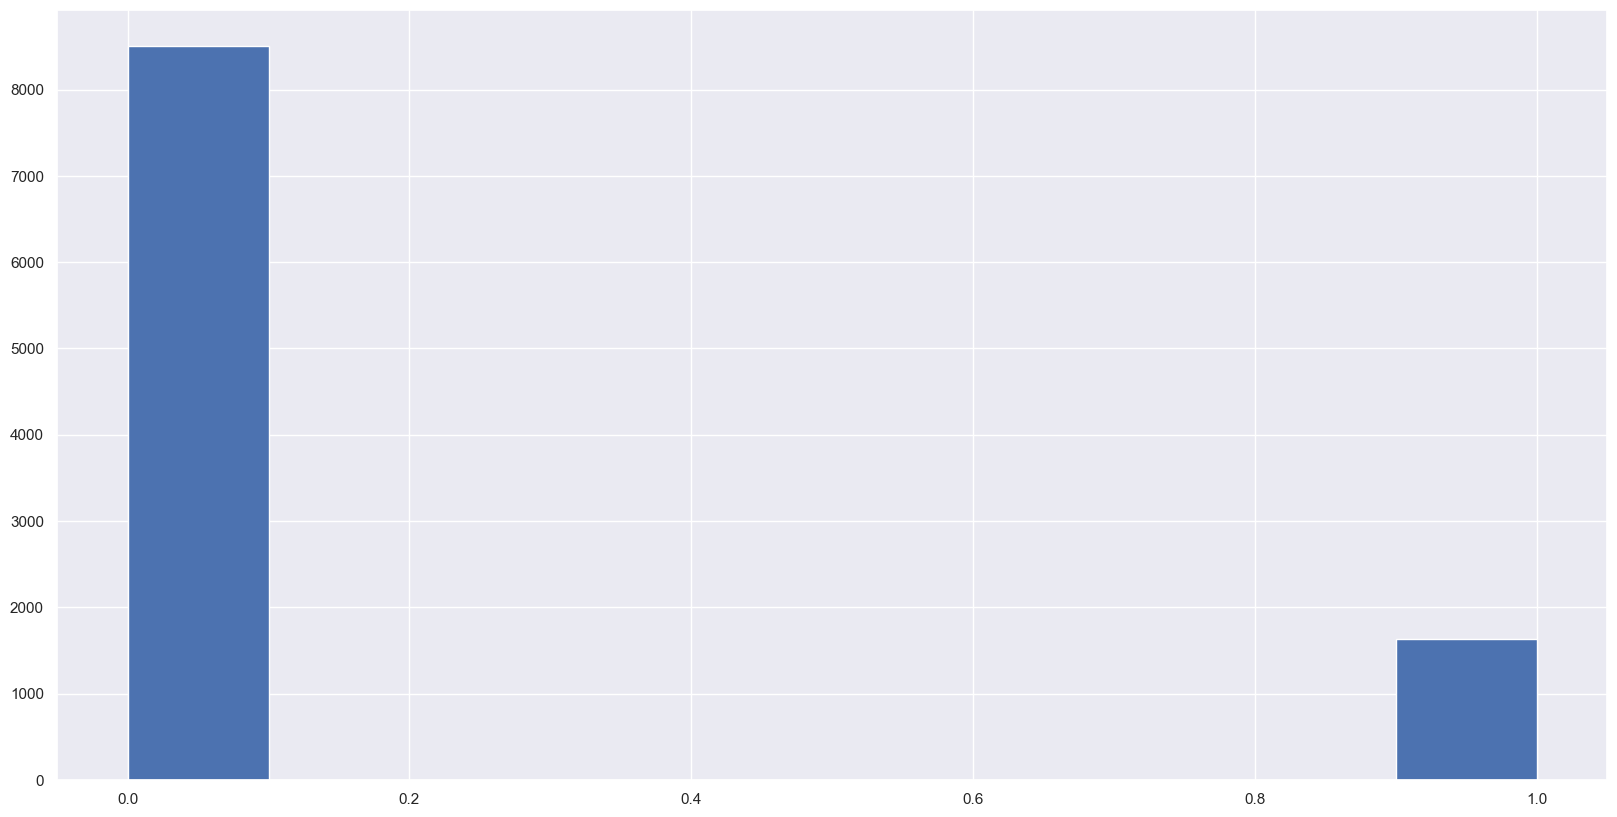

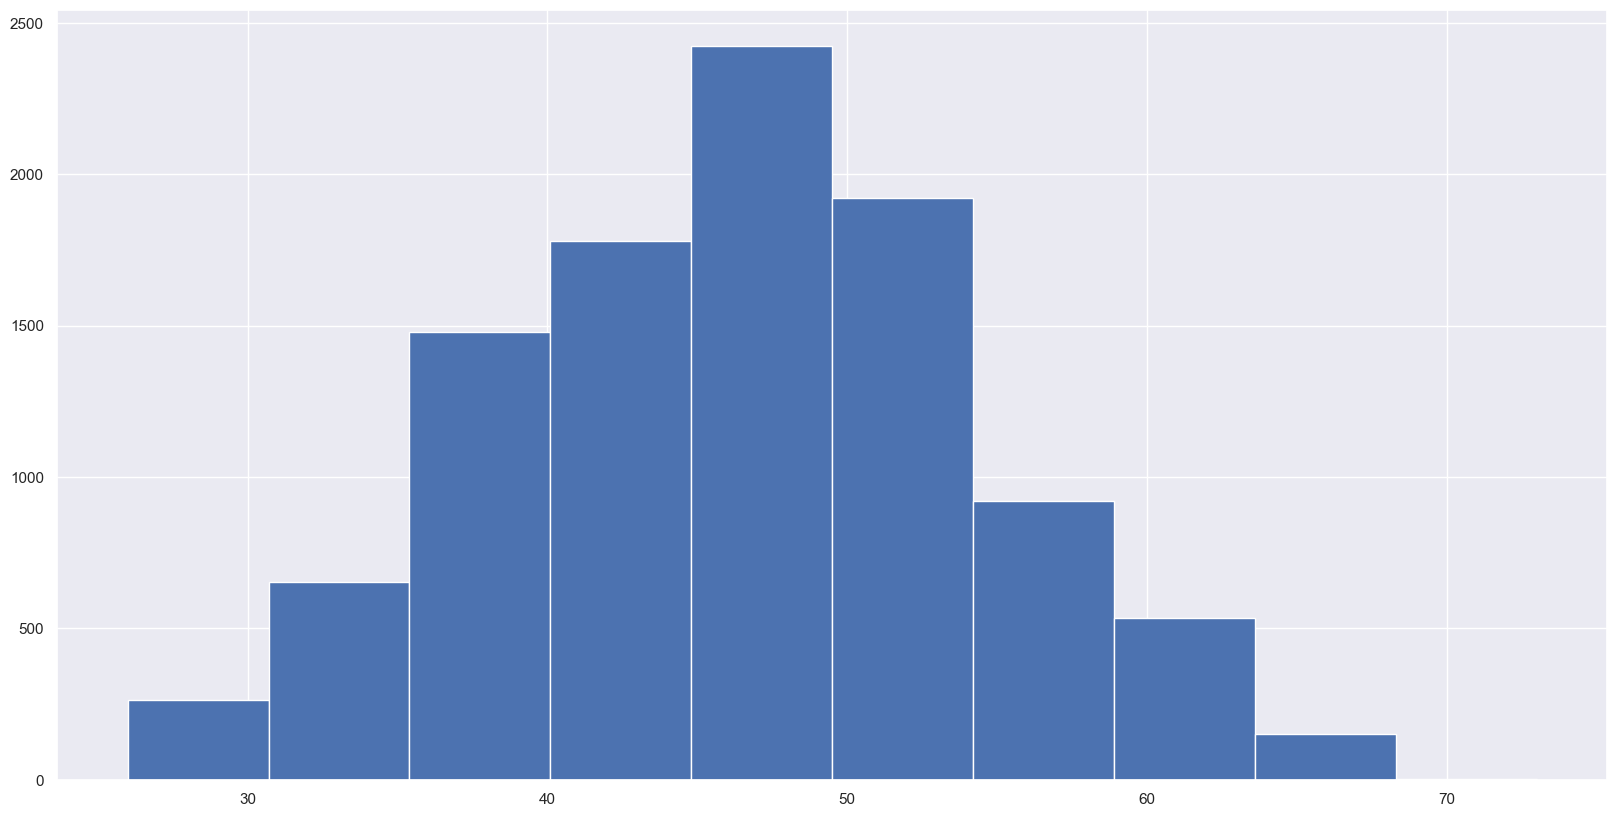

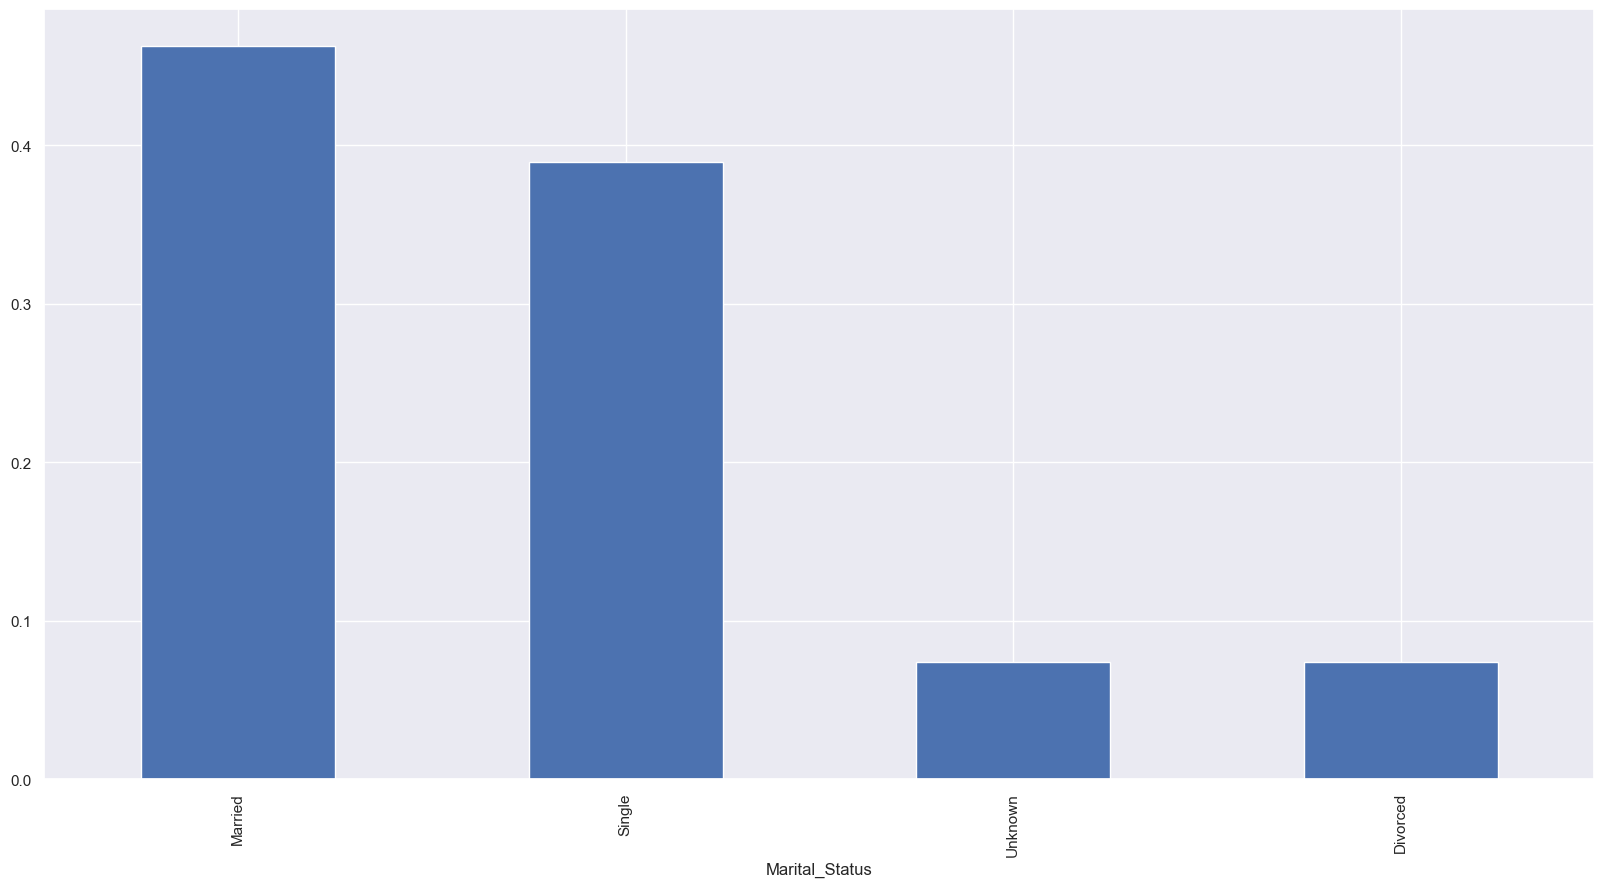

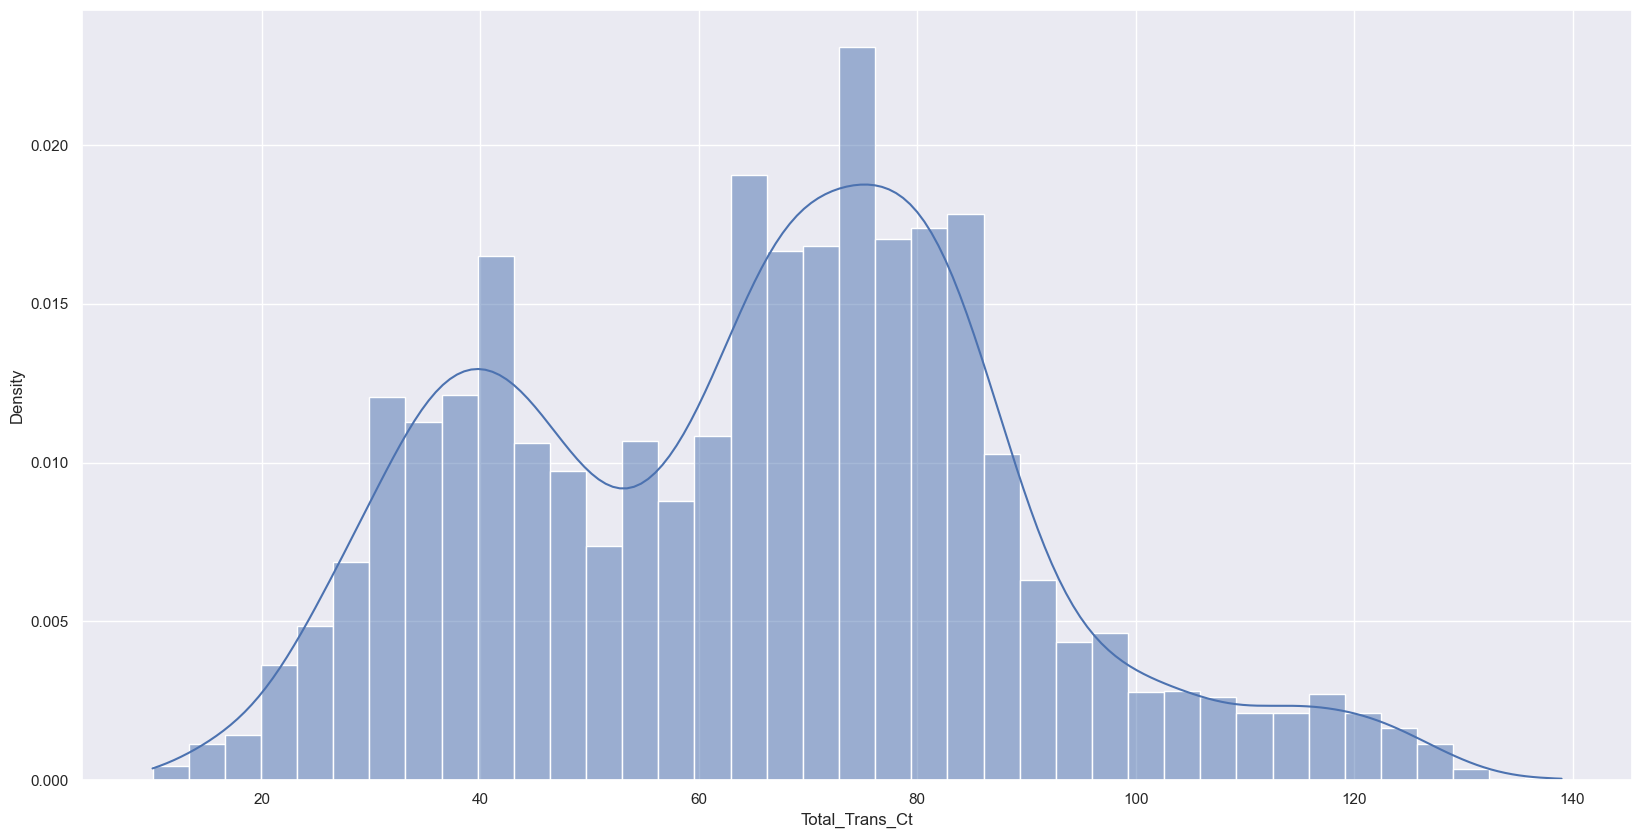

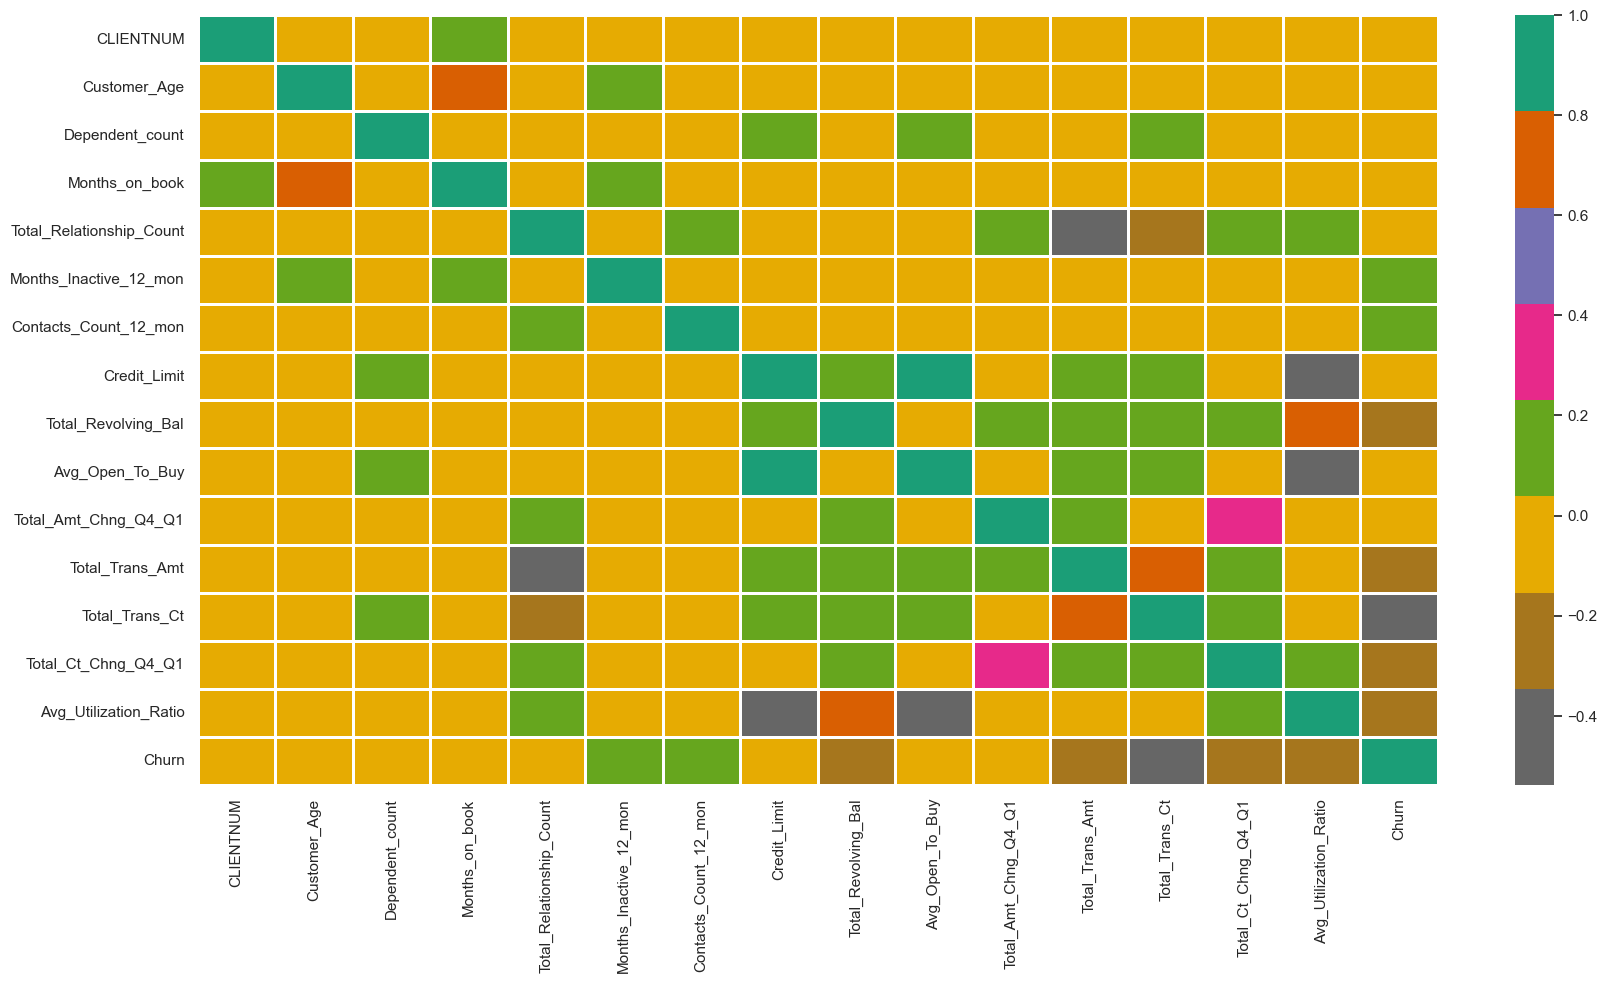

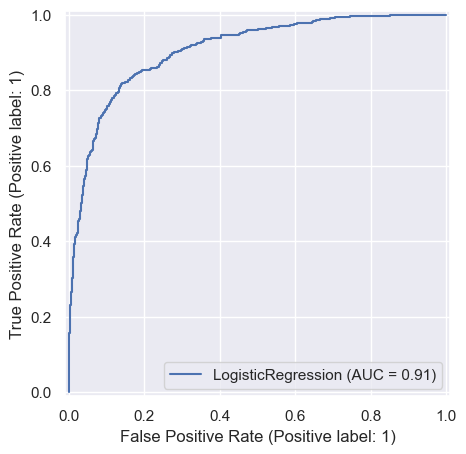

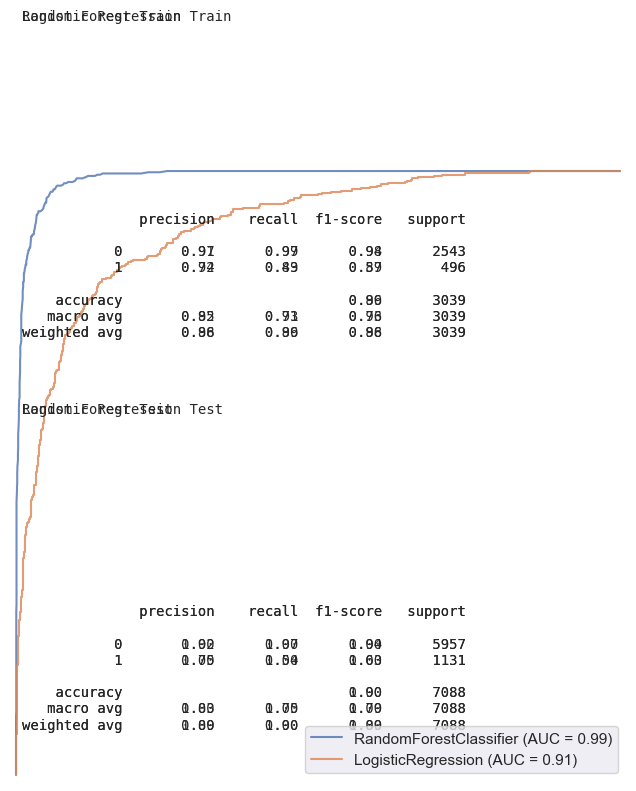

<Figure size 500x500 with 0 Axes>

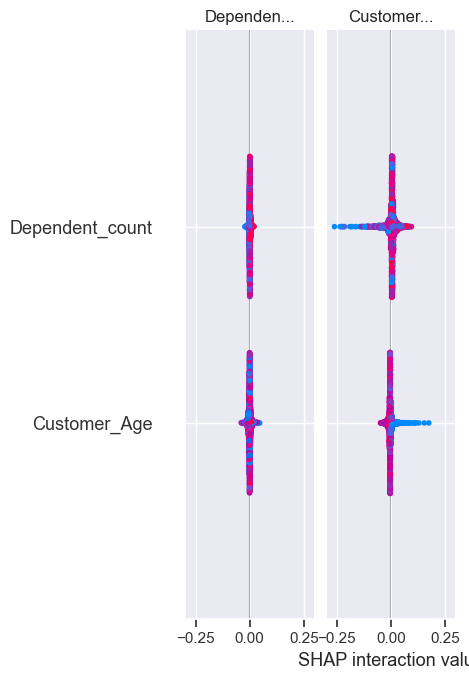

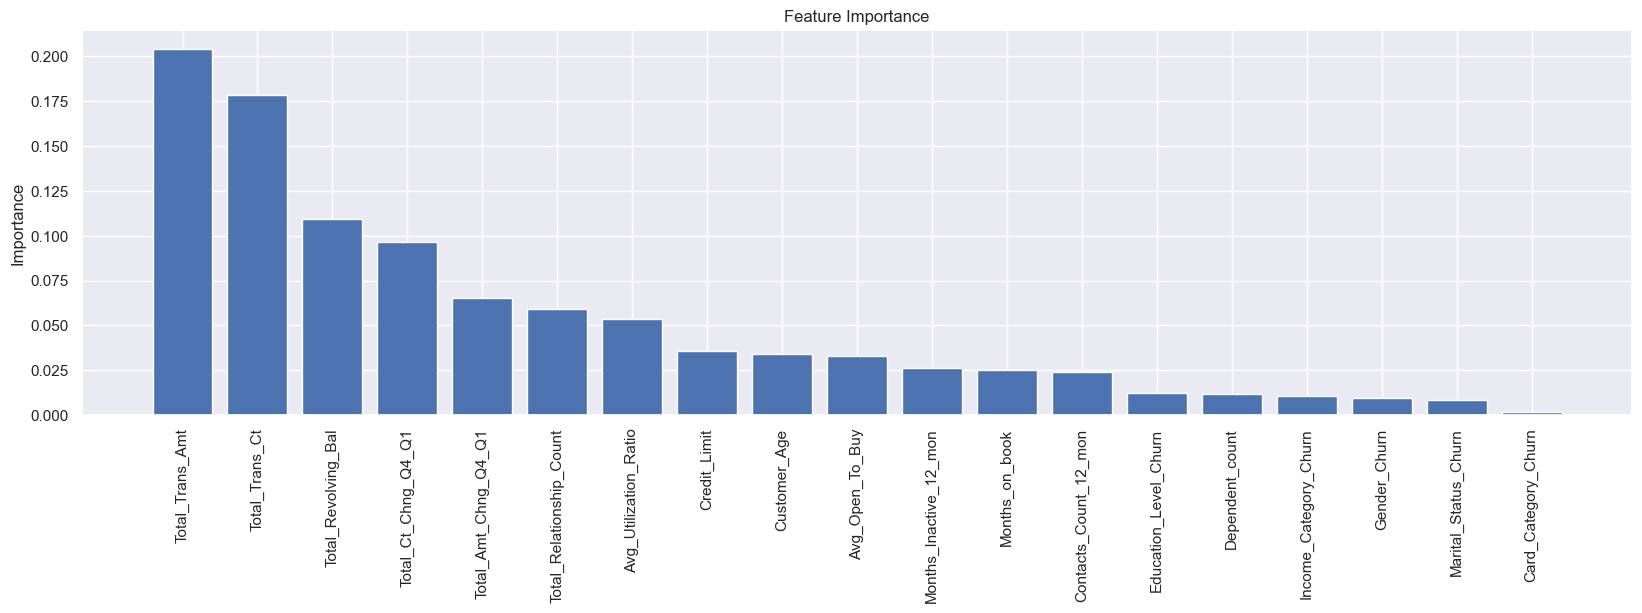

In [123]:
if __name__ == "__main__":
    logging.info("SUCCESS: Started run at %s.", datetime.now())
    driver(path)
    logging.info("SUCCESS: Completed entire modelling run at %s!", datetime.now())